## Proses Instalasi

In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [2]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

Using TensorFlow backend.


## Prapemrosesan Data

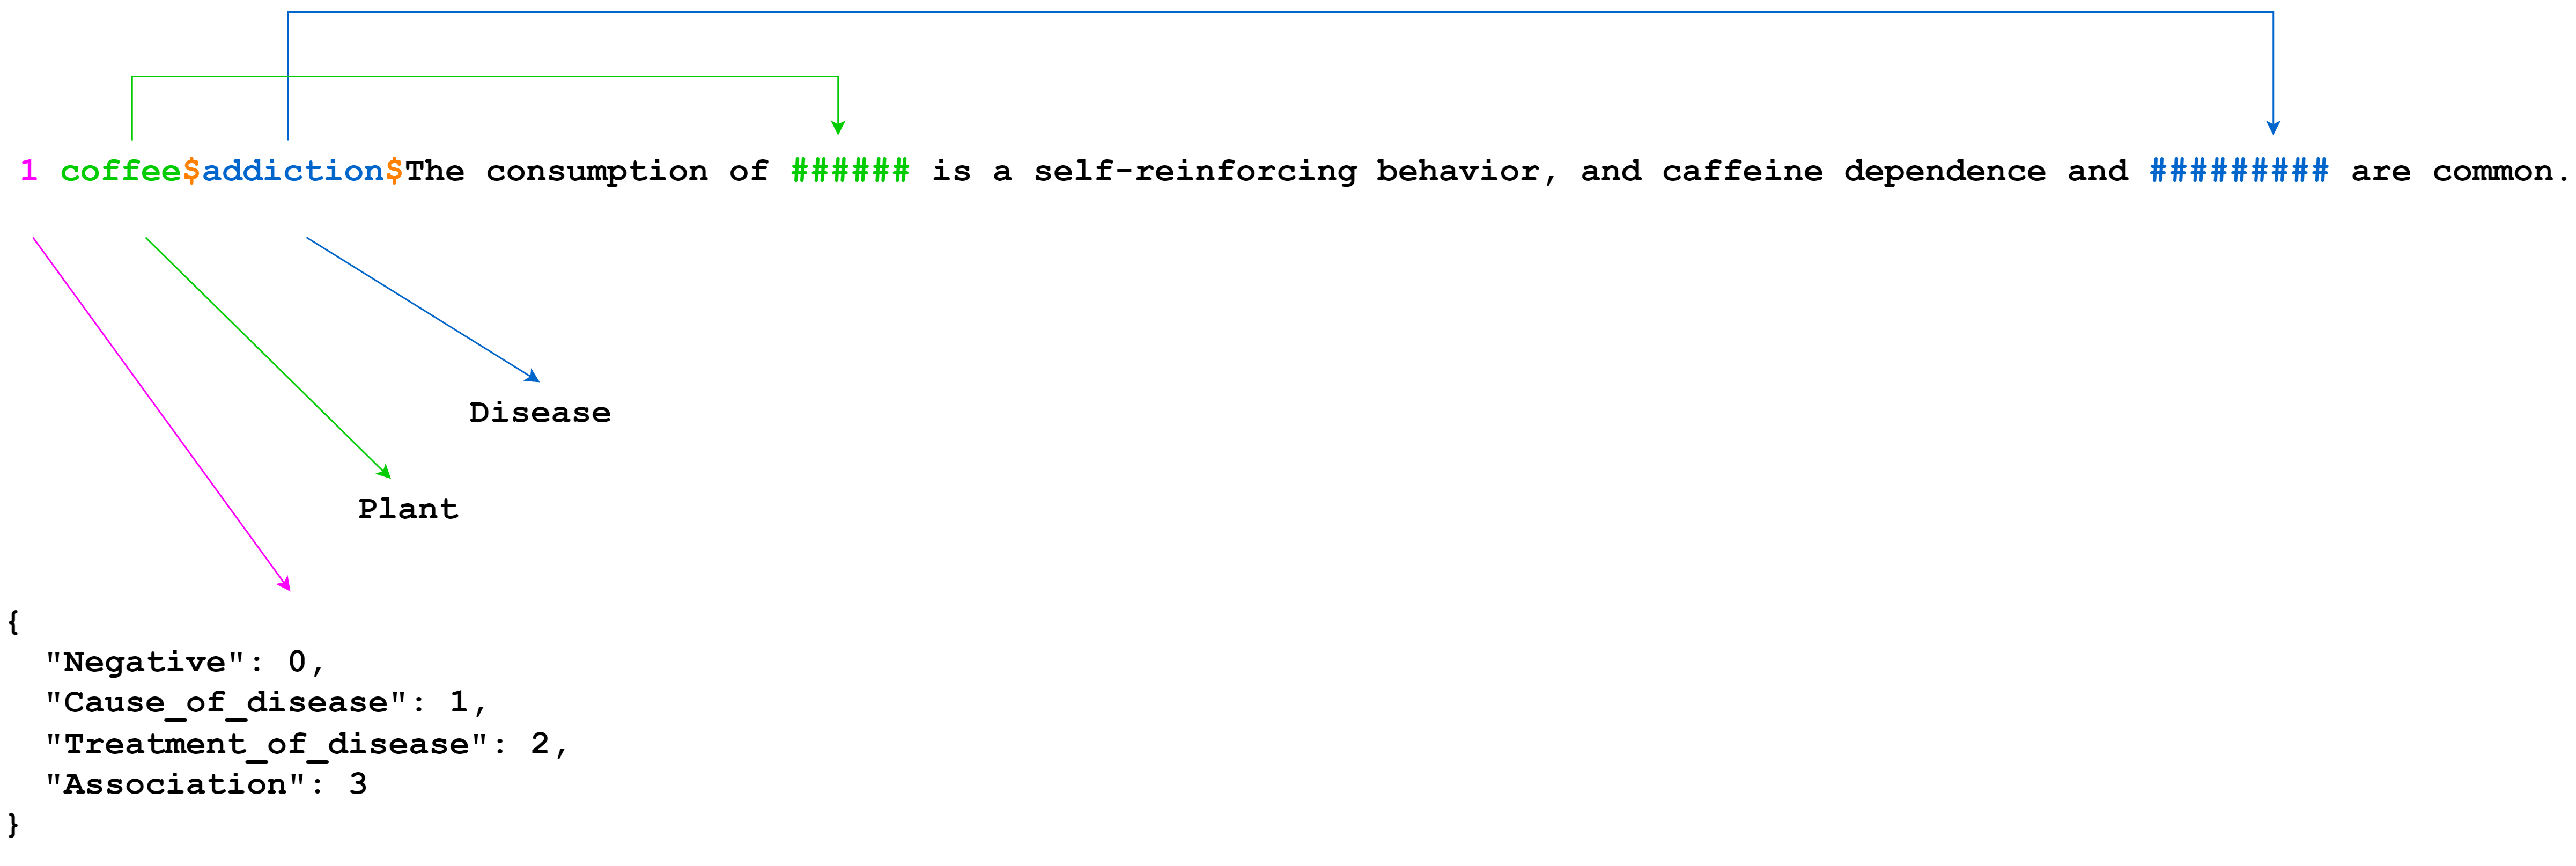

In [3]:
from IPython import display
display.Image("XtoT.png")

In [3]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [4]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split

# Train

### Encoding Oversampling

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Load data using get_train_test_pd() function
train_df, test_df = get_train_test_pd()

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
train_df, train_labels = ros.fit_resample(train_df[['text']], train_df['label'])

# Initialize BERT model
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)

# Define function for encoding text using BERT model
def encode_text(text):
    return bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_data = [encode_text(text) for text in train_df['text'].values]
test_data = [encode_text(text) for text in test_df['text'].values]

# Split train and test sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)

# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


Train data shape: (1488, 256, 768), Train labels shape: (1488,)
Val data shape: (372, 256, 768), Val labels shape: (372,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [21]:
# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")

Train data shape: (104,), Train labels shape: (83,)
Val data shape: (261,), Val labels shape: (21,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [7]:
#train_data, val_data, train_labels, val_labels 

x_train = train_data
x_test = val_data
y_train = train_labels
y_test = val_labels

### Training and Test Set

In [8]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [9]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [11]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (1488, 256, 768)
Size of training output data :  (1488, 4)
Size of testing input data :  (372, 256, 768)
Size of testing output data :  (372, 4)


## Model Config

In [12]:
inputs = Input(name="Input", shape=(256, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [13]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = 'output/oversampling/e40-dr03-b64-dim256'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

## Model Visualization

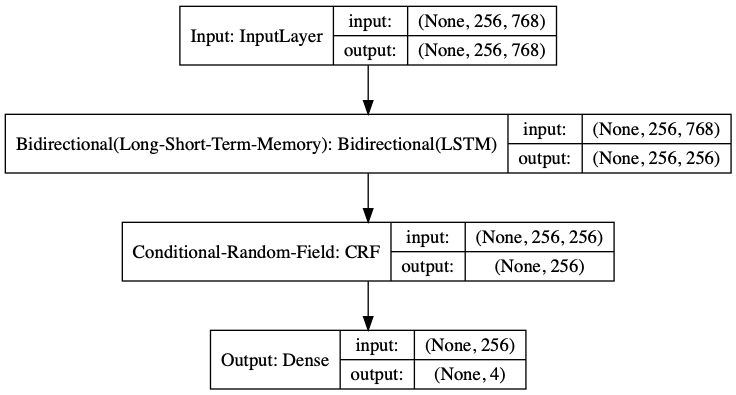

In [14]:
plot_model(model, to_file='model.png', show_shapes=True)

# Model Process

In [15]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 256, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 256, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1284      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 920,840
Trainable params: 920,840
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [27]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Uji 1

In [17]:
# Save the latest val_acc best model file
filepath="output/oversampling/e40-dr03-b64-dim256/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [18]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1488 samples, validate on 372 samples
Epoch 1/40
1488/1488 [==============================] - 32s 21ms/step - loss: 1.3661 - accuracy: 0.2708 - val_loss: 1.2620 - val_accuracy: 0.3656

Epoch 00001: val_accuracy improved from -inf to 0.36559, saving model to output/oversampling/e40-dr03-b64-dim256/e-01-los-1.2620-acc-0.3656.hdf5
Epoch 2/40
1488/1488 [==============================] - 27s 18ms/step - loss: 1.1170 - accuracy: 0.5101 - val_loss: 1.1335 - val_accuracy: 0.4301

Epoch 00002: val_accuracy improved from 0.36559 to 0.43011, saving model to output/oversampling/e40-dr03-b64-dim256/e-02-los-1.1335-acc-0.4301.hdf5
Epoch 3/40
1488/1488 [==============================] - 27s 18ms/step - loss: 0.8592 - accuracy: 0.6223 - val_loss: 0.7175 - val_accuracy: 0.6855

Epoch 00003: val_accuracy improved from 0.43011 to 0.68548, saving model to output/oversampling/e40-dr03-b64-dim256/e-03-los-0.7175-acc-0.6855.hdf5
Epoch 4/40
1488/1488 [==============================] - 26s 18ms/step -

In [45]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

21/21 [==============================] - 0s 9ms/step
The effect on the test set： [0.7133297920227051, 0.7142857313156128]


# Uji Skema 1

In [20]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [22]:
model = load_model(
  "output/oversampling/e40-dr03-b64-dim256/e-38-los-0.4263-acc-0.8790.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.80      0.72      0.76        95
    Cause_of_disease       0.93      0.94      0.93        95
Treatment_of_disease       0.78      0.86      0.82        86
         Association       1.00      1.00      1.00        96

            accuracy                           0.88       372
           macro avg       0.88      0.88      0.88       372
        weighted avg       0.88      0.88      0.88       372



dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


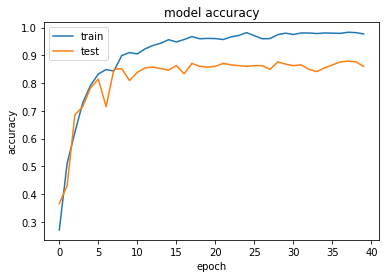

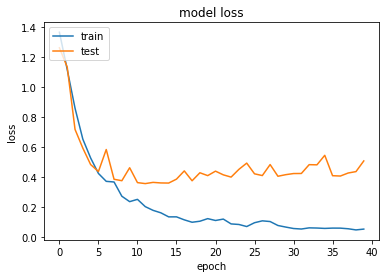

In [23]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   1.261985      0.365591  1.366061  0.270833
1   1.133538      0.430108  1.117012  0.510081
2   0.717466      0.685484  0.859181  0.622312
3   0.592347      0.715054  0.652408  0.728495
4   0.482691      0.782258  0.526541  0.791667
5   0.436178      0.814516  0.423267  0.832661
6   0.583057      0.715054  0.370642  0.848790
7   0.384519      0.849462  0.366368  0.843414
8   0.374864      0.852151  0.271175  0.899194
9   0.461466      0.809140  0.235122  0.909946
10  0.362146      0.838710  0.250410  0.905242
11  0.355611      0.854839  0.201814  0.923387
12  0.363708      0.857527  0.176994  0.935484
13  0.359976      0.852151  0.160460  0.943548
14  0.359238      0.846774  0.133477  0.956317
15  0.385370      0.862903  0.133578  0.948253
16  0.440243      0.833333  0.113624  0.956989
17  0.374504      0.870968  0.097584  0.967742
18  0.427900      0.860215  0.104354  0.959677
19  0.408916      0.857527  0.121701  0.961021
20  0.438692 

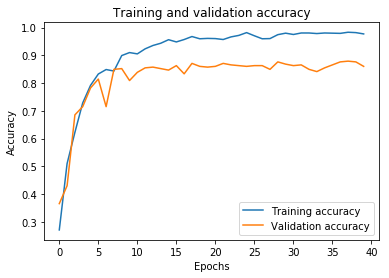

In [25]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
from random import randint

# Predict

In [2]:
import os, json
import numpy as np
from extract_feature import BertVector
from keras.models import load_model
from att import Attention
from utils.crf import CRF

model = load_model(
  "output/oversampling/e40-dr03-b64-dim256/e-38-los-0.4263-acc-0.8790.hdf5", 
  custom_objects={"CRF": CRF})

# Example Statements and Preprocessing
#text1 = 'green tea#skin papillomas#Inhibitory effect of green tea on the growth of established skin papillomas in mice.'
text1 = "pecan#atopics#Of the pecan atopics 65.2% had clinical symptoms coinciding only with the pecan pollen season and an additional 10.9% had perennial symptoms."
per1, per2, doc = text1.split('#')
text = '$'.join([per1, per2, doc.replace(per1, len(per1)*'#').replace(per2, len(per2)*'#')])
print(text)


bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)
vec = bert_model.encode([text])["encodes"][0]
x_train = np.array([vec])

predicted = model.predict(x_train)
y = np.argmax(predicted[0])

with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    rel_dict = json.load(f)

id_rel_dict = {v:k for k,v in rel_dict.items()}
print('original: %s' % text1)
print('Predict entity relationships: %s' % id_rel_dict[y])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


I:BERT_VEC:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 55]:build graph...


pecan$atopics$Of the ##### ####### 65.2% had clinical symptoms coinciding only with the ##### pollen season and an additional 10.9% had perennial symptoms.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:BERT_VEC:[graph:opt:132]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:134]:freeze...
I:BERT_VEC:[graph:opt:137]:optimize...
I:BERT_VEC:[graph:opt:148]:write graph to a tmp file: tmp_graph21


original: pecan#atopics#Of the pecan atopics 65.2% had clinical symptoms coinciding only with the pecan pollen season and an additional 10.9% had perennial symptoms.
Predict entity relationships: Cause_of_disease
